<a href="https://colab.research.google.com/github/longhtt/Homelessness/blob/main/DATA_3320_Homelessness_Analysis_Long_Tran_Thien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

the purpose of this analysis on homelessness is to find out how much, or how well can we predict homelessness rates based on local housing market factors 

## Import libraries

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# Train-test splits
from sklearn.model_selection import train_test_split

# Model preprocessing
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm


# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

#Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

#Train-test splits and cross validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

from scipy.stats import uniform, randint

#Models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
import statsmodels.api as sm

#Model metrics
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix

#Missing data
import missingno as msno

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

#Train-test splits and cross validation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform, randint
import xgboost as xgb

# Model metrics and analysis
from sklearn.metrics import  mean_squared_error, mean_absolute_error

# plot tree model
import graphviz

## Load clean data

##### $\rightarrow$ Load the clean data set from Github. 

In [302]:
df = pd.read_csv('https://raw.githubusercontent.com/longhtt/Homelessness/main/clean_homeless_data.csv')

##### $\rightarrow$ Review the contents of the data set.

In [303]:
df.columns

Index(['coc_number', 'total_unsheltered', 'total_population',
       'house_price_index_2009', 'log_median_rent', 'utility_costs',
       'percentage_owners_cost_burden_2016',
       'percentage_renters_severe_cost_burden_2016', 'share_renters_2016',
       'rental_vacancy_rate', 'high_housing_density', 'number_eviction',
       'share_overcrowded_units_2016', 'city_or_urban', 'suburban',
       'rate_unemployment', 'gini_coefficient_2016', 'poverty_rate',
       'share_HUD_units', 'HUD_unit_occupancy_rate', 'share_built_before_1940',
       'total_population_65_plus', 'net_migration', 'migration_4_year_change',
       'proportion_one_person_households', 'share_under_18_with_single_parent',
       'share_veteran_status', 'share_no_bachelors',
       'medicare_reimbursements_per_enrollee', 'percentage_excessive_drinking',
       'average_Jan_temperature', 'average_summer_temperature',
       'total_Jan_precipitation', 'total_annual_precipitation',
       'rate_homeless', 'percent_black'

## State your questions

The overall problem is to determine whether and how housing market factors are related to homelessness. To answer this general problem, you will need to ask specific questions about the data.


1. What columns are predictors in the model?

2. How well does a multiple linear regression model fit the full data set?

3. What predictors are important?

4. Do we need to transform anything nonlinearly?

## Analysis

## Prepare the data for modeling

df still holds total type columns when we will only be using rate columns for our models and graphs. so dropping all total columns

In [304]:
df = df.drop(columns=['total_unsheltered', 'total_population', 'total_population_65_plus', 'total_Jan_precipitation', 'total_annual_precipitation'])

In [305]:
df.columns

Index(['coc_number', 'house_price_index_2009', 'log_median_rent',
       'utility_costs', 'percentage_owners_cost_burden_2016',
       'percentage_renters_severe_cost_burden_2016', 'share_renters_2016',
       'rental_vacancy_rate', 'high_housing_density', 'number_eviction',
       'share_overcrowded_units_2016', 'city_or_urban', 'suburban',
       'rate_unemployment', 'gini_coefficient_2016', 'poverty_rate',
       'share_HUD_units', 'HUD_unit_occupancy_rate', 'share_built_before_1940',
       'net_migration', 'migration_4_year_change',
       'proportion_one_person_households', 'share_under_18_with_single_parent',
       'share_veteran_status', 'share_no_bachelors',
       'medicare_reimbursements_per_enrollee', 'percentage_excessive_drinking',
       'average_Jan_temperature', 'average_summer_temperature',
       'rate_homeless', 'percent_black', 'percent_latino_hispanic',
       'percent_asian', 'percent_pacific_islander', 'percent_population_0_19',
       'percent_population_65_pl

Define the matrix of predictor variables X to be all columns except coc_number and rate_homeless and define the output variable y to be the rate_homeless. 

In [306]:
X = df.drop(columns = ['coc_number', 'rate_homeless'])
y = df['rate_homeless']

##### $\rightarrow$ Split the data into training and testing sets. Keep 20% of the data for the test set.

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 8647)

Examine the shape of the training data matrix of predictors.

In [308]:
print(X_train.shape, np.round(X_train.shape[0]/X_train.shape[1]))

(299, 35) 9.0


##### $\rightarrow$ Center the variables using the median and scale with the inter-quartile range. We use the RobustScaler here because many variables have skewed distributions.

In [309]:
from sklearn.preprocessing import RobustScaler

Define the scaler using only the training data. For the validation set approach to work, we can not incorporate any knowledge of the validation set's properties into the model building process.

In [310]:
scaler = RobustScaler().fit(X_train)

Perform the scaling transform on the predictors in the training and testing sets.

In [311]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Use statsmodels to examine the statistical signficance of the coefficients.

Fit the model.

In [312]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit() 
# print(model.summary())

Display the predictor name and the p-value of the estimated coefficient.

In [313]:
variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(index = variables, data = {'p-value':model.pvalues.values.round(3), 'significant': model.pvalues.values < 0.05})

,p-value,significant
intercept,0.000,True
house_price_index_2009,0.206,False
log_median_rent,0.000,True
utility_costs,0.425,False
percentage_owners_cost_burden_2016,0.999,False
percentage_renters_severe_cost_burden_2016,0.780,False
share_renters_2016,0.340,False
rental_vacancy_rate,0.289,False
high_housing_density,0.076,False
number_eviction,0.133,False


There are too many variables in the model. We are likely overfitting. We will use regularization methods and dimensionality reduction methods to build a model.

 Use the model to predict the test data. Compute the MSE, RMSE, and  R2 .

In [314]:
MSE = mean_squared_error(y_test, model.predict(sm.add_constant(X_test)))
RMSE = np.sqrt(MSE)
R_squared = r2_score(y_test, model.predict(sm.add_constant(X_test)))

print('MSE =', MSE.round(3), ' RMSE =', RMSE.round(3), ' R-squared =', R_squared.round(3))

MSE = 108.761  RMSE = 10.429  R-squared = 0.446


### Lasso


Lasso regression finds the parameters in the linear model by minimizing a penalized squared error:

$$C(\boldsymbol{\beta}) = \sum_{i=1}^n(y_i - \beta_{0} - \sum_{j=1}^p\beta_{j}x_{ij})^2 + \alpha \sum_{j=1}^p|\beta_{j}| = \text{RSS} + \alpha \sum_{j=1}^p|\beta_{j}|$$

There is a hyperparameter $\alpha$ that influences the performance. We will use cross validation to determine the best value.

##### $\rightarrow$ To understand how $\alpha$ changes the fit, note that when $\alpha$ is large, some coefficients are set to zero.

Create an array of possible $\alpha$ values.

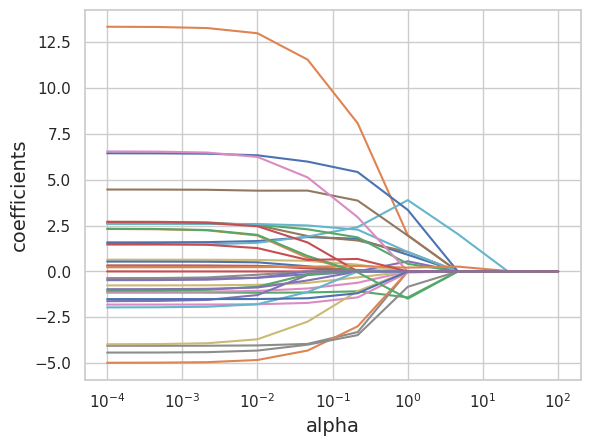

In [315]:
alphas = 10**np.linspace(-4,2,10)
lasso = Lasso(max_iter = 100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

 Do 5-fold cross validation to find  α

In [316]:
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)
lassocv.fit(X_train, y_train)
lassocv.alpha_

0.2596614120236473

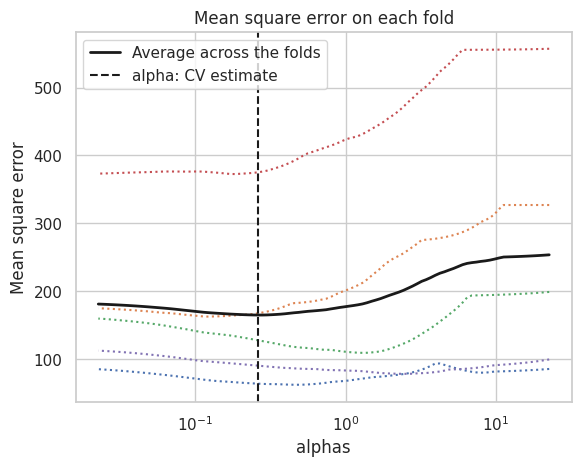

In [317]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, ":")
plt.plot(
    lassocv.alphas_ ,
    lassocv.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lassocv.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight");

 Fit the Lasso model on the training data with the best  α  and examine the coefficients.

In [318]:
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)
coefficients = lasso_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, lasso_reg.intercept_.round(4))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')
pd.DataFrame(data = coefficients.round(2), index = variables, columns = ['Estimated Coefficient'])

,Estimated Coefficient
intercept,14.47
house_price_index_2009,1.80
log_median_rent,7.50
utility_costs,-1.12
percentage_owners_cost_burden_2016,0.00
percentage_renters_severe_cost_burden_2016,0.12
share_renters_2016,1.62
rental_vacancy_rate,-0.53
high_housing_density,-2.99
number_eviction,0.32


Use the lasso model to predict the test data. Compute the MSE, RMSE, and  R2. 

In [319]:
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

print('MSE =', MSE_lasso.round(3), ' RMSE =', RMSE_lasso.round(3), ' R-squared =', R_squared_lasso.round(3))

MSE = 107.722  RMSE = 10.379  R-squared = 0.451


Make a scatter plot of the measured log sale price vs. the predicted log sale price.

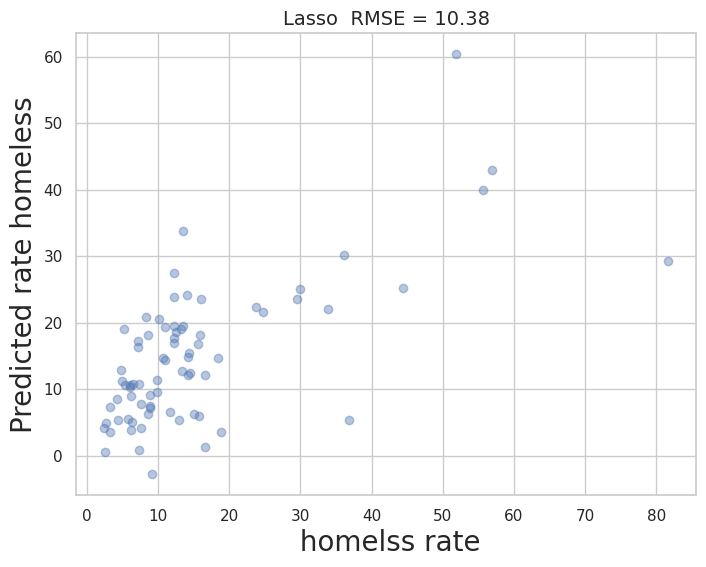

In [320]:
plt.figure(figsize=(8,6))

plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4)

plt.xlabel(' homelss rate',fontsize = 20)
plt.ylabel('Predicted rate homeless',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14);

### Ridge regressiona

Ridge regression finds the parameters in the linear model by minimizing a penalized squared error:

$$C(\boldsymbol{\beta}) = \sum_{i=1}^n(y_i - \beta_{0} - \sum_{j=1}^p\beta_{j}x_{ij})^2 + \alpha \sum_{j=1}^p\beta_{j}^2 = \text{RSS} + \alpha \sum_{j=1}^p\beta_{j}^2$$

There is a hyperparameter $\alpha$ that influences the performance. We will use cross validation to determine the best value.

Create an array of possible $\alpha$ values. and To understand how $\alpha$ changes the fit, note that when $\alpha$ increases, all coefficients are scaled to be smaller.

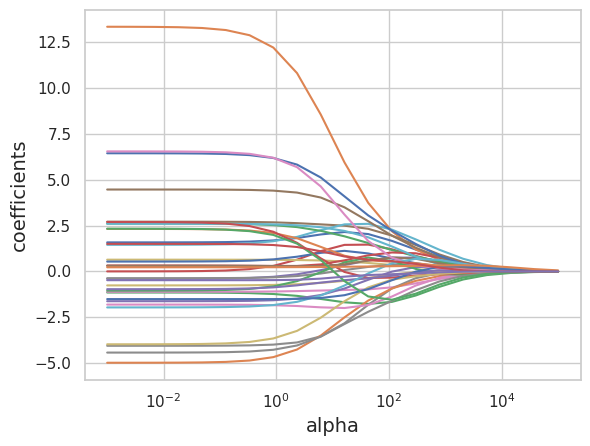

In [321]:
alphas = 10**np.linspace(-3,5,20)
ridge = Ridge(max_iter = 100000)
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

##### $\rightarrow$ Use cross-validation to find the best alpha for Ridge regression.

Do 5-fold cross validation 

In [322]:
ridgecv = RidgeCV(alphas = alphas, cv = 5, scoring = 'neg_mean_squared_error')

ridgecv.fit(X_train, y_train);

Print the best $\alpha$

In [323]:
ridgecv.alpha_

42.81332398719396

##### $\rightarrow$ Fit the ridge regression model on the training data with the best $\alpha$ and examine the coefficients.

In [324]:
ridge_reg = Ridge(alpha = ridgecv.alpha_).fit(X_train, y_train)
coefficients = ridge_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, ridge_reg.intercept_.round(3))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(data = coefficients, index = variables, columns = ['Estimated Coefficient'])

,Estimated Coefficient
intercept,13.557
house_price_index_2009,2.039
log_median_rent,3.740
utility_costs,-1.769
percentage_owners_cost_burden_2016,1.463
percentage_renters_severe_cost_burden_2016,0.593
share_renters_2016,2.325
rental_vacancy_rate,-0.977
high_housing_density,-1.818
number_eviction,0.463


Use the ridge regression model to predict the test data. Compute the MSE, RMSE, and  R2 .

In [325]:
MSE_ridge = mean_squared_error(y_test, ridge_reg.predict(X_test))
RMSE_ridge = np.sqrt(MSE_ridge)
R_squared_ridge = r2_score(y_test, ridge_reg.predict(X_test))

print('MSE =', MSE_ridge.round(3), ' RMSE =', RMSE_ridge.round(3), ' R-squared =', R_squared_ridge.round(3))

MSE = 109.019  RMSE = 10.441  R-squared = 0.445


Make a scatter plot of the measured rate homeless vs. the predicted rate homeless.

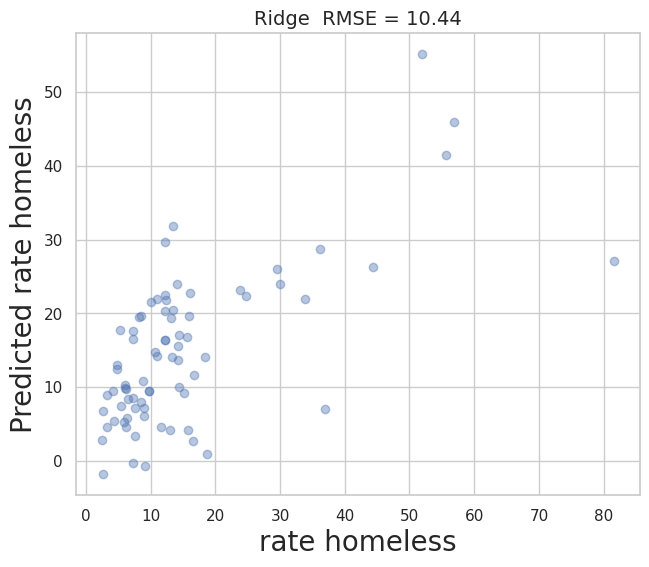

In [326]:
plt.figure(figsize=(16,6))

#plt.subplot(1,2,1)
#plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4)
#plt.xlabel('rate homeless',fontsize = 20)
#plt.ylabel('Predicted rate homeless',fontsize = 20)
#plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14)

plt.subplot(1,2,2)
plt.plot(y_test, ridge_reg.predict(X_test),'o', alpha = 0.4)
plt.xlabel('rate homeless',fontsize = 20)
plt.ylabel('Predicted rate homeless',fontsize = 20)
plt.title('Ridge' + ' ' + ' RMSE = ' + str(RMSE_ridge.round(2)),fontsize = 14);

plt.subplots_adjust(hspace = 0.5)

# XGBoost

## Prepare the data for modeling

## f

In [327]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 10)

In [328]:
model_lr = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [329]:
y_pred_lr = model_lr.predict(sm.add_constant(X_test))

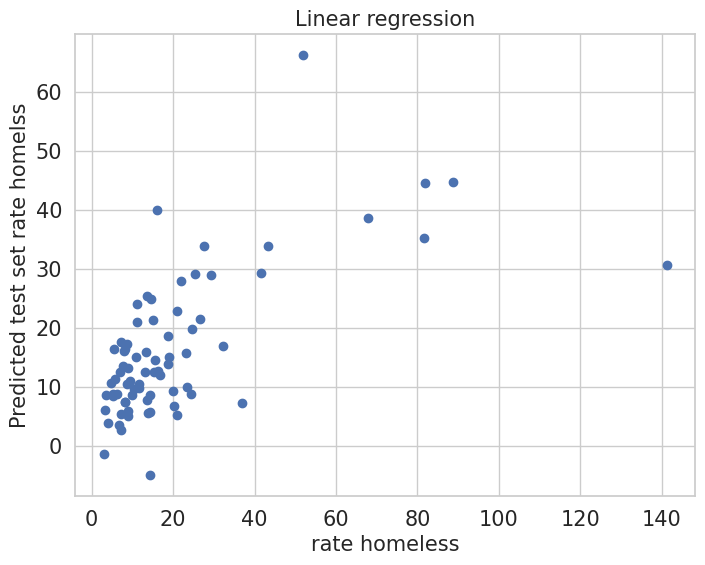

In [330]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_lr, 'o');

plt.xlabel('rate homeless', fontsize = 15)
plt.ylabel('Predicted test set rate homelss', fontsize = 15)
plt.title('Linear regression', fontsize = 15)


plt.tick_params(labelsize = 15)

In [331]:
mean_squared_error(y_test, y_pred_lr, squared = False).round(3)

17.83

In [332]:
mean_absolute_error(y_test, y_pred_lr).round(3)

9.686

XGBoost is short for eXtreme Gradient Boosting.
→  Use cross-validation to find the best parameters for an XGBoost model. This takes a while to run.

In [333]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True, scoring = 'neg_mean_squared_error')

search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8808f35450>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8808f34be0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8808f35180>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8808f35780>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

colsample_bytree : Subsample ratio of columns when constructing each tree.
        

gamma : (min_split_loss) Minimum loss reduction required to make a further partition on a leaf node of the tree.
        


learning_rate : Boosting learning rate (xgb's "eta")


max_depth :  Maximum tree depth for base learners.

n_estimators : Number of gradient boosted trees.  Equivalent to number of boosting rounds.

subsample : Subsample ratio of the training instance.

In [334]:
search.best_params_

{'colsample_bytree': 0.816226269123602,
 'gamma': 0.3838386036386828,
 'learning_rate': 0.18522373631915512,
 'max_depth': 5,
 'n_estimators': 146,
 'subsample': 0.6142996020468021}

In [335]:
#model_xgb = xgb.XGBRegressor(objective="reg:squarederror", 
#                             colsample_bytree=search.best_params_['colsample_bytree'],
#                             n_estimators=search.best_params_['n_estimators'],
#                             learning_rate=search.best_params_['learning_rate'],
#                             max_depth=search.best_params_['max_depth'],
#                             subsample=search.best_params_['subsample'],
#                             gamma=search.best_params_['gamma'])                            

Create an XGBoost model with the best parameters

In [336]:
model_xgb = xgb.XGBRegressor(objective="reg:squarederror")
model_xgb.set_params(**search.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.816226269123602, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3838386036386828, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.18522373631915512, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=146, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Fit the model on the training data

In [337]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.816226269123602, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3838386036386828, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.18522373631915512, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=146, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Predict the test data

In [338]:
y_pred_xgb = model_xgb.predict(X_test)

Plot the test values of `y` vs. the predicted values

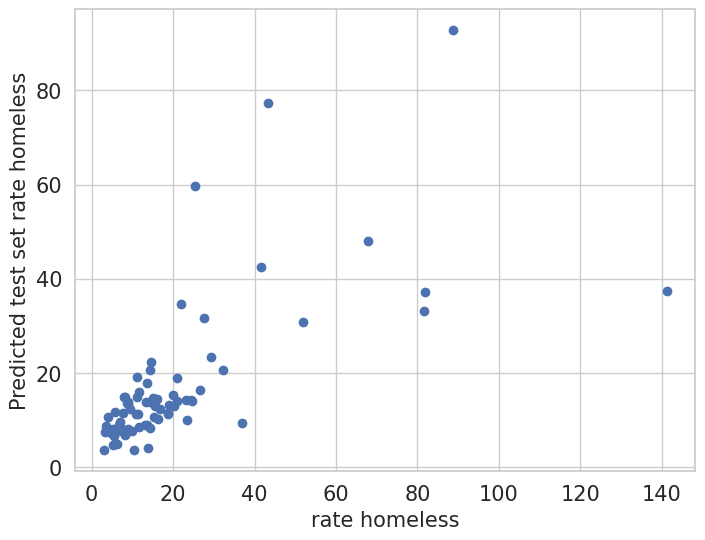

In [339]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_xgb, 'o');

plt.xlabel('rate homeless', fontsize = 15)
plt.ylabel('Predicted test set rate homeless', fontsize = 15)

plt.tick_params(labelsize = 15)

Compute the RMSE

In [340]:
mean_squared_error(y_test, y_pred_xgb, squared = False).round(3)

16.786

Compute the mean absolute error

In [341]:
mean_absolute_error(y_test, y_pred_xgb).round(3)

8.475

Plot the variable importances for the XGBoost model.

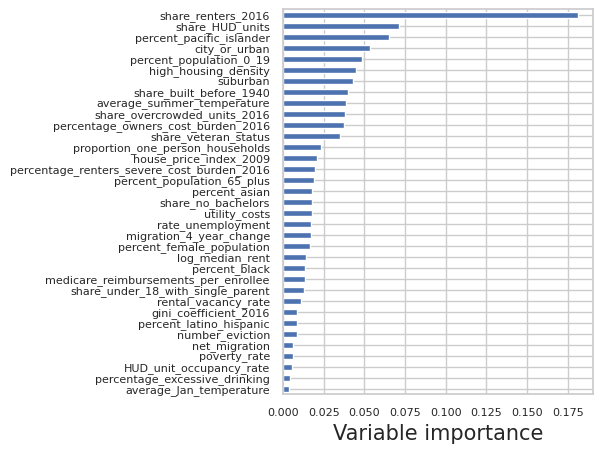

In [342]:
(pd.DataFrame(dict(cols=X_train.columns, imp=model_xgb.feature_importances_)).
 sort_values(by = 'imp').
 plot('cols', 'imp', 'barh', legend = False, figsize = (4,5)))

plt.ylabel('')
plt.xlabel('Variable importance', fontsize = 15)

plt.tick_params(labelsize = 8);

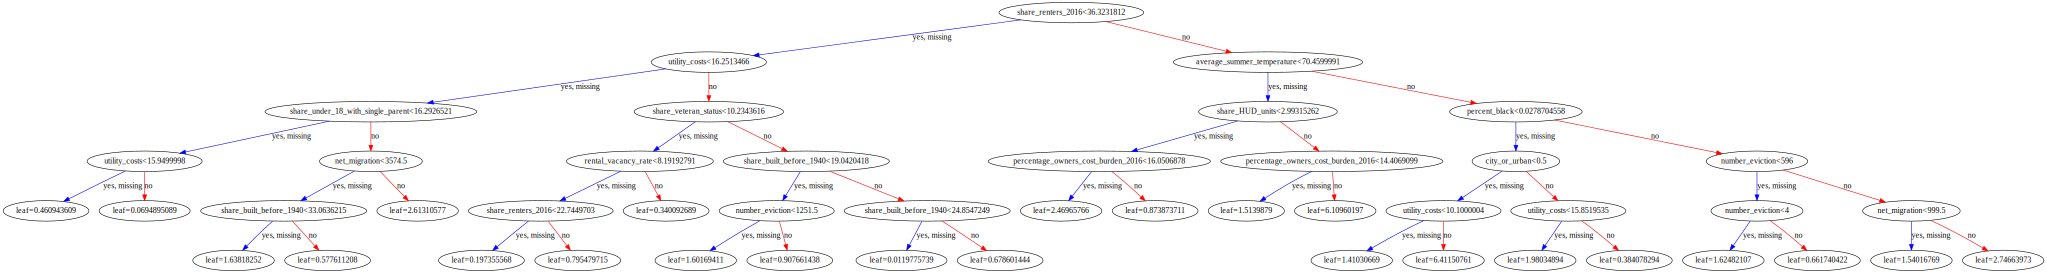

In [343]:
xgb.to_graphviz(model_xgb, num_trees=1) # Try different values of num_trees to plot other trees

## addition question

we also want to ask: 
Do homelessness rates vary by district type ? (urban, suburban)? 
<br> using the same data and calculation below but now showing city or urban points and suburban or non-suburban points

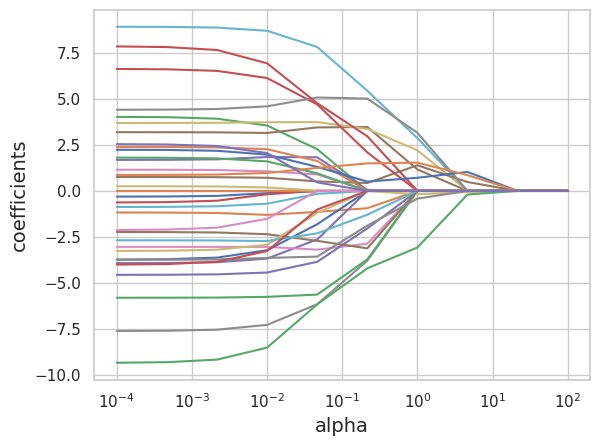

In [344]:
X = df.drop(columns = ['coc_number', 'rate_homeless']).loc[df['city_or_urban'] == 1]
y = df['rate_homeless'].loc[df['city_or_urban'] == 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 8647)
scaler = RobustScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
model = sm.OLS(y_train, sm.add_constant(X_train)).fit() 
variables = X.columns
variables = np.insert(variables, 0, 'intercept')
MSE = mean_squared_error(y_test, model.predict(sm.add_constant(X_test)))
RMSE = np.sqrt(MSE)
R_squared = r2_score(y_test, model.predict(sm.add_constant(X_test)))
alphas = 10**np.linspace(-4,2,10)
lasso = Lasso(max_iter = 100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

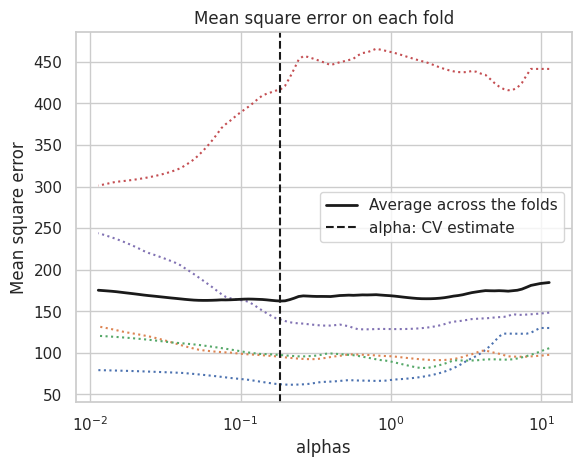

In [345]:
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)
lassocv.fit(X_train, y_train)
lassocv.alpha_
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, ":")
plt.plot(
    lassocv.alphas_ ,
    lassocv.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lassocv.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight");

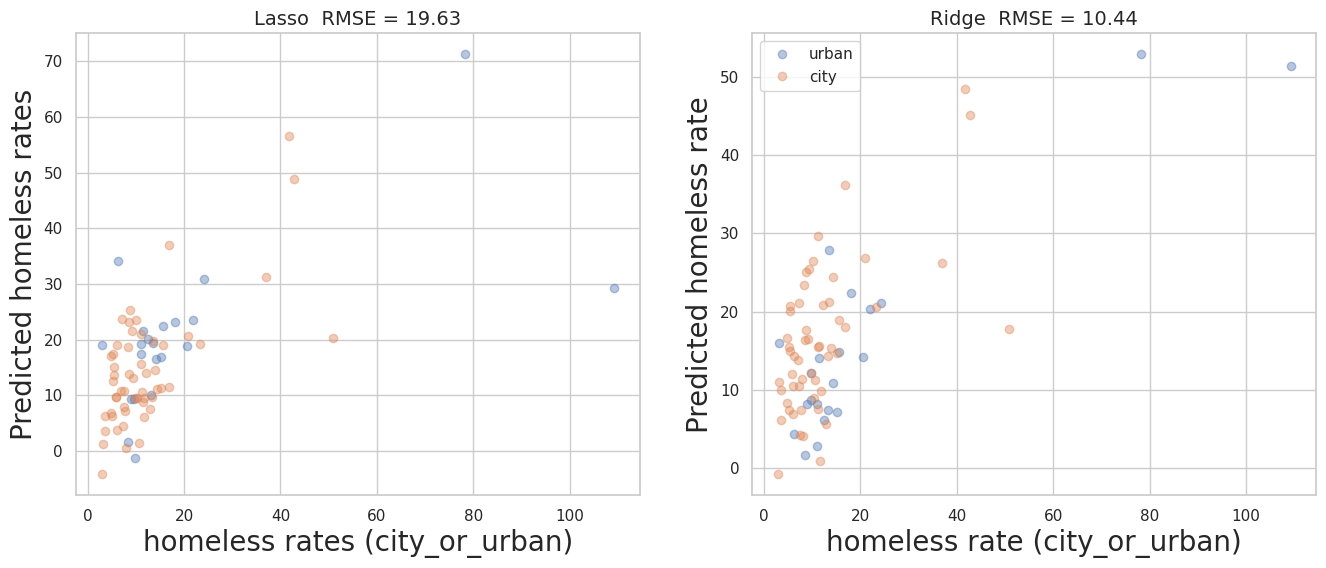

In [346]:
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)
coefficients = lasso_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, lasso_reg.intercept_.round(4))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4, label = "urban")
plt.xlabel('homeless rates (city_or_urban)',fontsize = 20)
plt.ylabel('Predicted homeless rates',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14)

plt.subplot(1,2,2)
plt.plot(y_test, ridge_reg.predict(X_test),'o', alpha = 0.4, label = "urban")
plt.xlabel('homeless rate (city_or_urban)',fontsize = 20)
plt.ylabel('Predicted homeless rate',fontsize = 20)
plt.title('Ridge' + ' ' + ' RMSE = ' + str(RMSE_ridge.round(2)),fontsize = 14);

X = df.drop(columns = ['coc_number', 'rate_homeless']).loc[df['city_or_urban'] == 0]
y = df['rate_homeless'].loc[df['city_or_urban'] == 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 8647)
scaler = RobustScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
model = sm.OLS(y_train, sm.add_constant(X_train)).fit() 
variables = X.columns
variables = np.insert(variables, 0, 'intercept')
MSE = mean_squared_error(y_test, model.predict(sm.add_constant(X_test)))
RMSE = np.sqrt(MSE)
R_squared = r2_score(y_test, model.predict(sm.add_constant(X_test)))
alphas = 10**np.linspace(-4,2,10)
lasso = Lasso(max_iter = 100000)
coefs = []

lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)
lassocv.fit(X_train, y_train)
lassocv.alpha_
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)
coefficients = lasso_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, lasso_reg.intercept_.round(4))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

plt.subplot(1,2,1)
plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4, label = "city")

plt.subplot(1,2,2)
plt.plot(y_test, ridge_reg.predict(X_test),'o', alpha = 0.4, label = "city")

plt.subplots_adjust(hspace = 0.5)

plt.legend(loc="upper left")
plt.show()

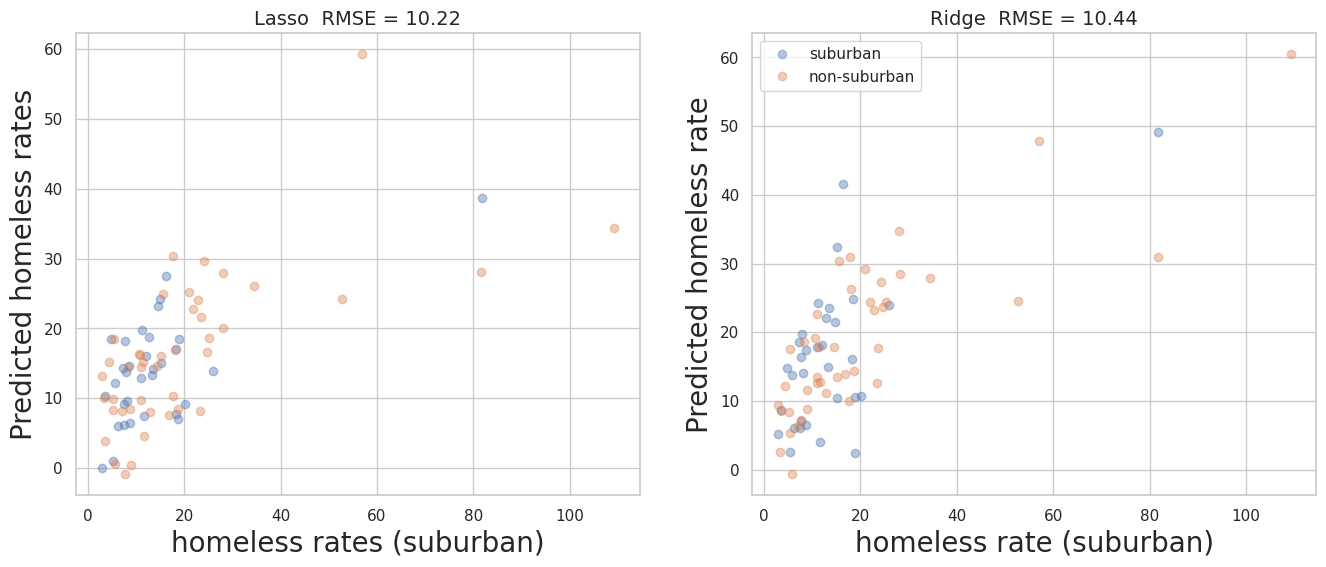

In [347]:
X = df.drop(columns = ['coc_number', 'rate_homeless']).loc[df['suburban'] == 1]
y = df['rate_homeless'].loc[df['suburban'] == 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 8647)
scaler = RobustScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
model = sm.OLS(y_train, sm.add_constant(X_train)).fit() 
variables = X.columns
variables = np.insert(variables, 0, 'intercept')
MSE = mean_squared_error(y_test, model.predict(sm.add_constant(X_test)))
RMSE = np.sqrt(MSE)
R_squared = r2_score(y_test, model.predict(sm.add_constant(X_test)))
alphas = 10**np.linspace(-4,2,10)
lasso = Lasso(max_iter = 100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)
lassocv.fit(X_train, y_train)
lassocv.alpha_

lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)
coefficients = lasso_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, lasso_reg.intercept_.round(4))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4, label = "suburban")
plt.xlabel('homeless rates (suburban)',fontsize = 20)
plt.ylabel('Predicted homeless rates',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14)

plt.subplot(1,2,2)
plt.plot(y_test, ridge_reg.predict(X_test),'o', alpha = 0.4, label = "suburban")
plt.xlabel('homeless rate (suburban)',fontsize = 20)
plt.ylabel('Predicted homeless rate',fontsize = 20)
plt.title('Ridge' + ' ' + ' RMSE = ' + str(RMSE_ridge.round(2)),fontsize = 14);

X = df.drop(columns = ['coc_number', 'rate_homeless']).loc[df['suburban'] == 0]
y = df['rate_homeless'].loc[df['suburban'] == 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 8647)
scaler = RobustScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
model = sm.OLS(y_train, sm.add_constant(X_train)).fit() 
variables = X.columns
variables = np.insert(variables, 0, 'intercept')
MSE = mean_squared_error(y_test, model.predict(sm.add_constant(X_test)))
RMSE = np.sqrt(MSE)
R_squared = r2_score(y_test, model.predict(sm.add_constant(X_test)))
alphas = 10**np.linspace(-4,2,10)
lasso = Lasso(max_iter = 100000)
coefs = []

lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)
lassocv.fit(X_train, y_train)
lassocv.alpha_
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)
coefficients = lasso_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, lasso_reg.intercept_.round(4))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

plt.subplot(1,2,1)
plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4, label = "non-suburban")

plt.subplot(1,2,2)
plt.plot(y_test, ridge_reg.predict(X_test),'o', alpha = 0.4, label = "non-suburban")

plt.subplots_adjust(hspace = 0.5)

plt.legend(loc="upper left")
plt.show()


## conclusion

the overall aim of this analysis was to see how well or in correct term, how accurate can we predict homeless rate. Overall with changing the data to only include 2017 data and no other years. This makes our data very small to make an accurate prediction with. At most with using lasso, ridge regression and XGBoot, we would only get around 10%-15% accuracy in predicting homelss rates. This just goes to show how important it is to have a large data to help with prediction. if this was simply to show data, it would be fine, but prediction require much more.